In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR

In [ ]:
water_df = pd.read_csv('/content/water.csv')

In [ ]:
water_df.head()

,Time,WaterFlux
0,3600,10.262859
1,7200,11.779499
2,10800,11.832677
3,14400,11.791572
4,18000,12.104585


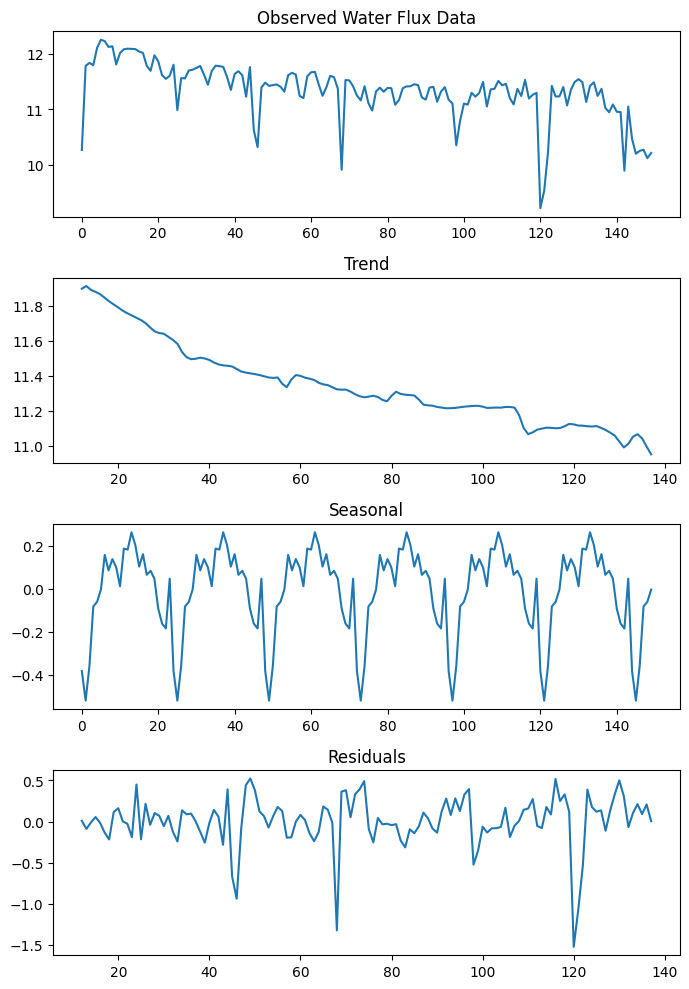

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

water_df = pd.read_csv("water.csv")

water_df["WaterFlux"] = pd.to_numeric(water_df["WaterFlux"], errors="coerce")
water_df.interpolate(method="linear", inplace=True)

decomposition_no_conversion = seasonal_decompose(water_df["WaterFlux"], period=24, model="additive")



fig, axes = plt.subplots(4, 1, figsize=(7, 10))

axes[0].plot(decomposition_no_conversion.observed); axes[0].set_title("Observed Water Flux Data")
axes[1].plot(decomposition_no_conversion.trend); axes[1].set_title("Trend")
axes[2].plot(decomposition_no_conversion.seasonal); axes[2].set_title("Seasonal")
axes[3].plot(decomposition_no_conversion.resid); axes[3].set_title("Residuals")


plt.tight_layout()
plt.show()

In [ ]:
adf_salt = adfuller(water_df['WaterFlux'].dropna())
print(f'ADF Statistic for WaterFlux: {adf_salt[0]}')
print(f'p-value: {adf_salt[1]}')

ADF Statistic for WaterFlux: -5.389973949670909
p-value: 3.555372055193227e-06


In [ ]:
water_df['WaterFlux Differenced'] = water_df['WaterFlux'].diff()
adf_salt_diff = adfuller(water_df['WaterFlux Differenced'].dropna())
print(f'ADF Statistic for WaterFlux Differenced: {adf_salt_diff[0]}')
print(f'p-value: {adf_salt_diff[1]}')

ADF Statistic for WaterFlux Differenced: -7.742094678644371
p-value: 1.0552872494351225e-11


In [ ]:
water_df.head()

,Time,WaterFlux,WaterFlux Differenced
0,3600,10.262859,NaN
1,7200,11.779499,1.516640
2,10800,11.832677,0.053178
3,14400,11.791572,-0.041106
4,18000,12.104585,0.313014


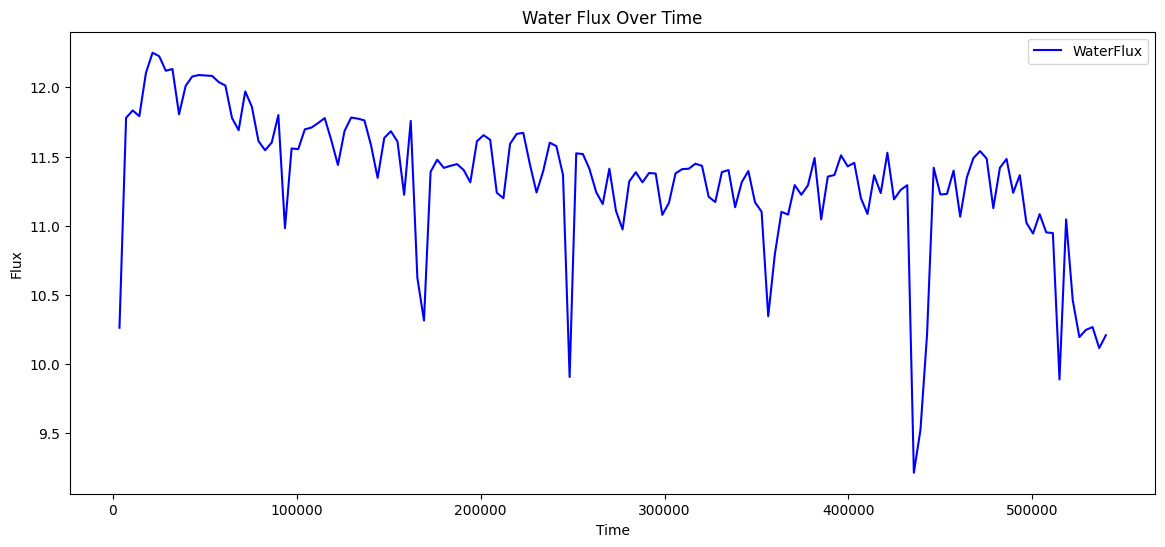

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(water_df['Time'], water_df['WaterFlux'], label="WaterFlux", color="b")
plt.title("Water Flux Over Time")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

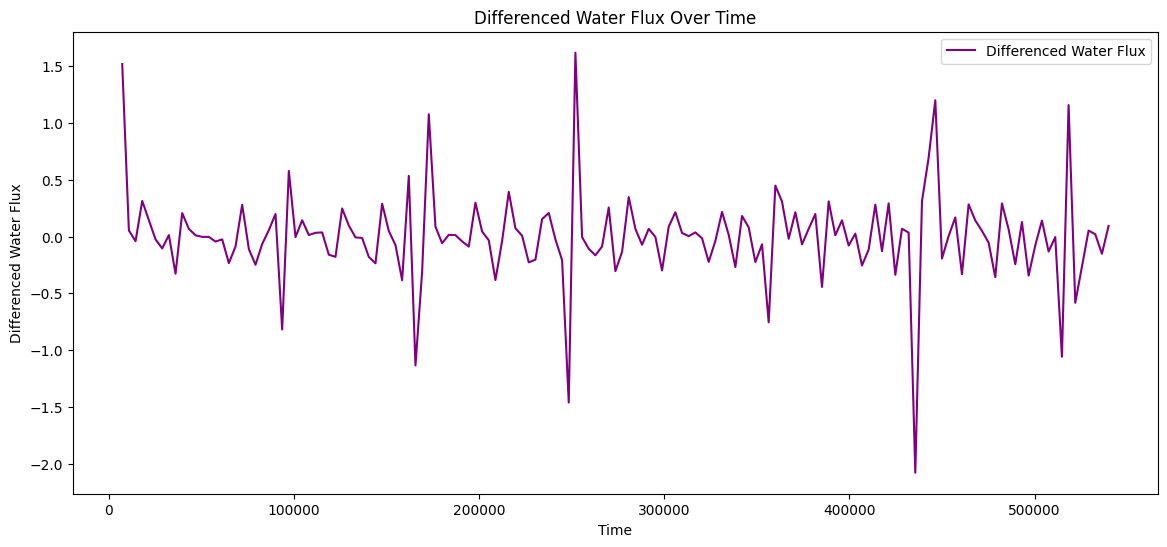

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(water_df['Time'], water_df['WaterFlux Differenced'], label="Differenced Water Flux", color="purple")
plt.title("Differenced Water Flux Over Time")
plt.xlabel("Time")
plt.ylabel("Differenced Water Flux")
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

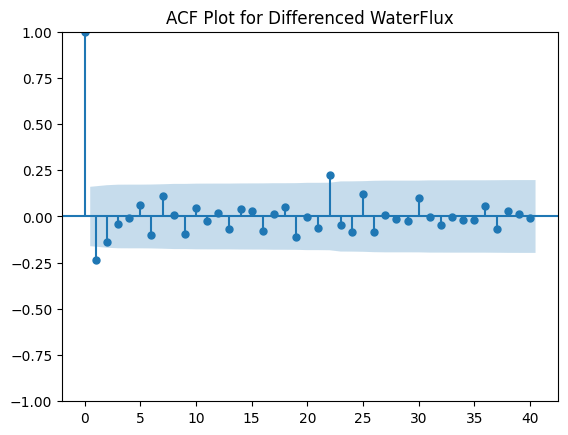

<Figure size 1200x600 with 0 Axes>

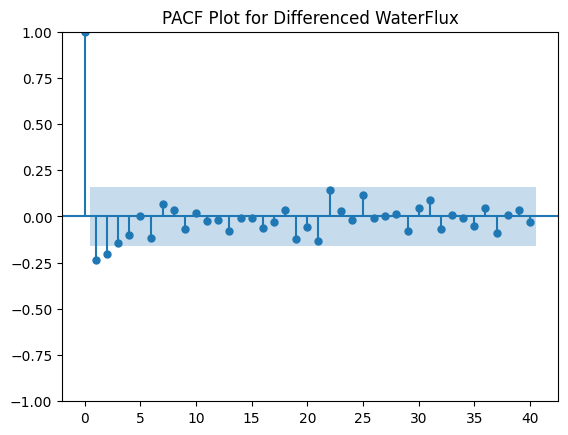

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(water_df['WaterFlux Differenced'].dropna(), lags=40)
plt.title("ACF Plot for Differenced WaterFlux")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(water_df['WaterFlux Differenced'].dropna(), lags=40)
plt.title("PACF Plot for Differenced WaterFlux")
plt.show()


In [ ]:
water_df['WaterFlux Differenced'] = water_df['WaterFlux'].diff(12)
water_df.dropna(subset=['WaterFlux Differenced'], inplace=True)
result = adfuller(water_df['WaterFlux Differenced'])
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')

ADF Statistic: -8.323361735936507, p-value: 3.5236140613156174e-13


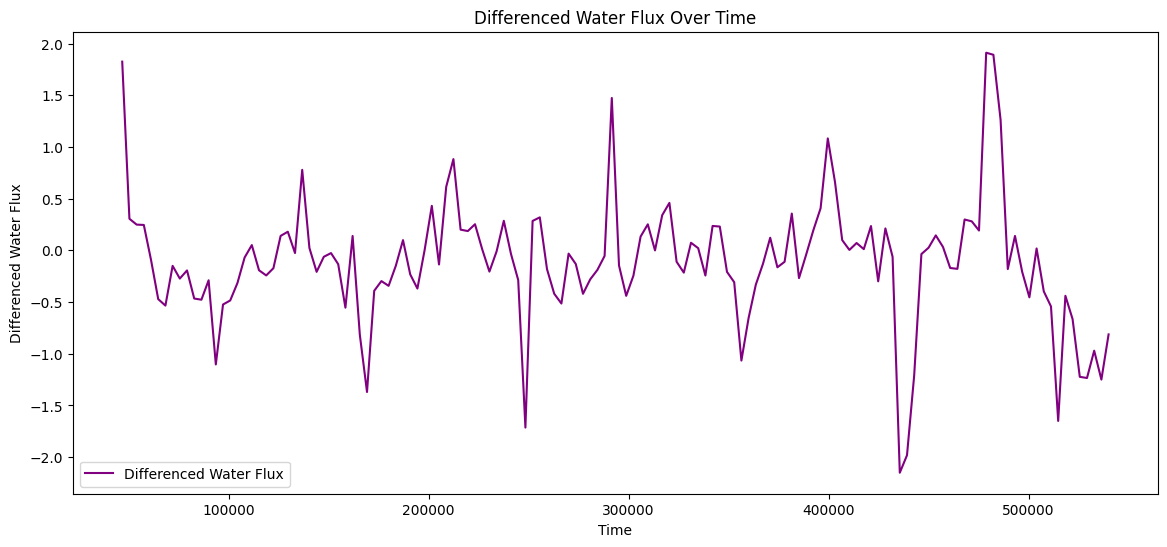

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(water_df['Time'], water_df['WaterFlux Differenced'], label="Differenced Water Flux", color="purple")
plt.title("Differenced Water Flux Over Time")
plt.xlabel("Time")
plt.ylabel("Differenced Water Flux")
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

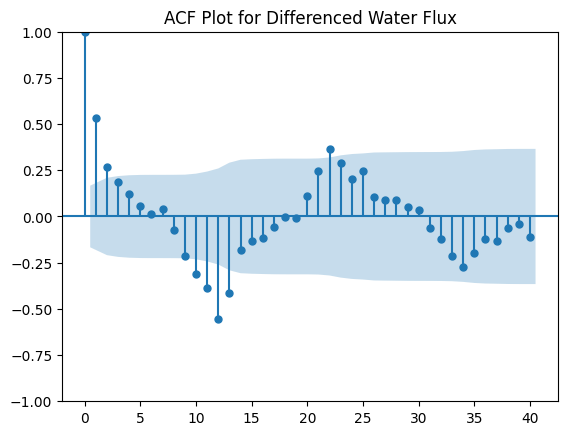

<Figure size 1200x600 with 0 Axes>

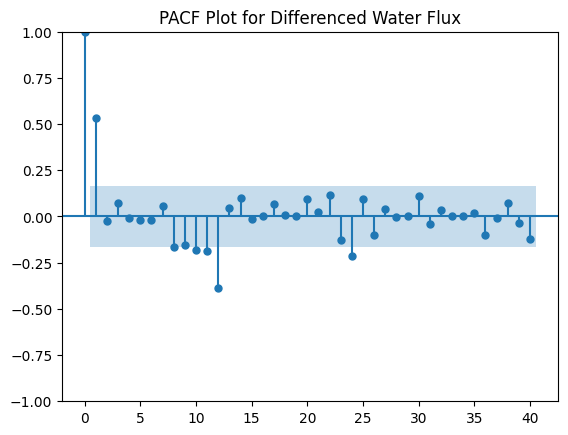

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(water_df['WaterFlux Differenced'].dropna(), lags=40)
plt.title("ACF Plot for Differenced Water Flux")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(water_df['WaterFlux Differenced'].dropna(), lags=40)
plt.title("PACF Plot for Differenced Water Flux")
plt.show()


In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima
SARIMA_model = auto_arima(water_df["WaterFlux Differenced"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=24,
                         start_P=1, start_Q=1,
                         max_P=3, max_Q=3,
                         seasonal=True,
                         d=1,
                         D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(SARIMA_model.summary())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=5.21 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=291.097, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=253.726, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=2.16 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=285.092, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=246.470, Time=2.90 sec
 ARIMA(1,1,0)(3,1,0)[24]             : AIC=241.811, Time=7.35 sec
 ARIMA(1,1,0)(3,1,1)[24]             : AIC=inf, Time=27.04 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=12.15 sec
 ARIMA(0,1,0)(3,1,0)[24]             : AIC=245.208, Time=2.77 sec
 ARIMA(2,1,0)(3,1,0)[24]             : AIC=234.830, Time=5.50 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=236.926, Time=4.43 sec
 ARIMA(2,1,0)(3,1,1)[24]             : AIC=inf, Time=35.18 sec
 ARIMA(2,1,0)(2,1,1)[24]             : 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


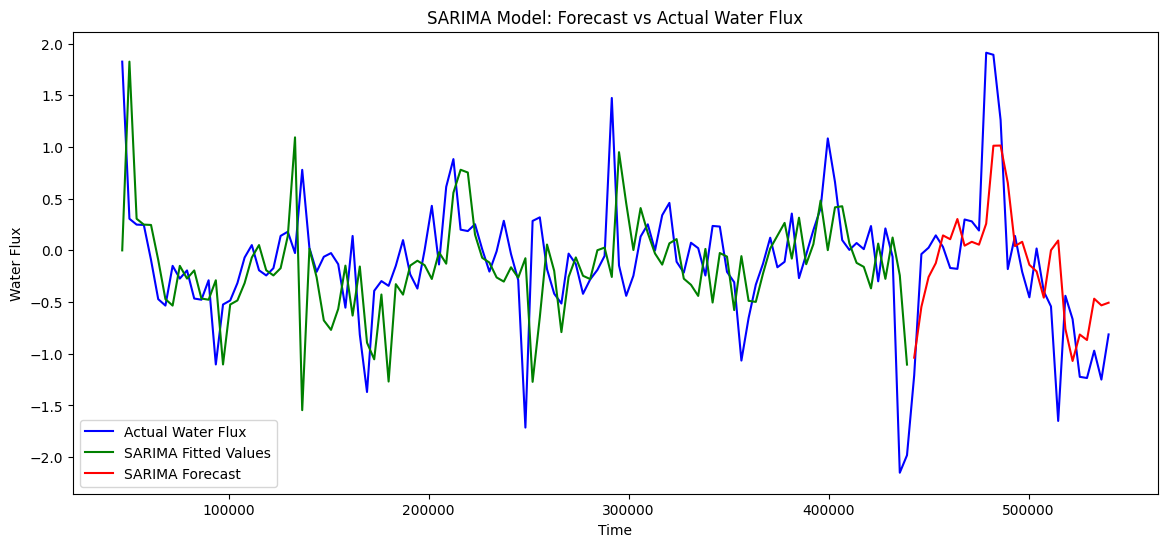

In [ ]:
train_size = int(len(water_df) * 0.8)
train, test = water_df['WaterFlux Differenced'][:train_size], water_df['WaterFlux Differenced'][train_size:]

P, D, Q, S = 2, 1, 0, 24
p, d, q = 1, 1, 1

sarima_model = SARIMAX(water_df['WaterFlux Differenced'], order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_result = sarima_model.fit()

sarima_fitted_values = sarima_result.predict(start=0, end=train_size - 1)
sarima_forecast = sarima_result.predict(start=train_size, end=len(water_df)-1,type='levels')

plt.figure(figsize=(14, 6))
plt.plot(water_df['Time'], water_df['WaterFlux Differenced'], label="Actual Water Flux", color="blue")

plt.plot(water_df['Time'][:train_size], sarima_fitted_values, label="SARIMA Fitted Values", color="green")

plt.plot(water_df['Time'][train_size:], sarima_forecast, label="SARIMA Forecast", color="red")

plt.title("SARIMA Model: Forecast vs Actual Water Flux")
plt.xlabel("Time")
plt.ylabel("Water Flux")
plt.legend()
plt.show()


In [ ]:
mae_test = mean_absolute_error(test, sarima_forecast)
mse_test = mean_squared_error(test, sarima_forecast)
rmse_test = np.sqrt(mse_test)
print(f"Test MAE: {mae_test:}")
print(f"Test MSE: {mse_test:}")
print(f"Test RMSE: {rmse_test:}")

Test MAE: 0.38823013011817203
Test MSE: 0.35517234488923083
Test RMSE: 0.5959633754596257


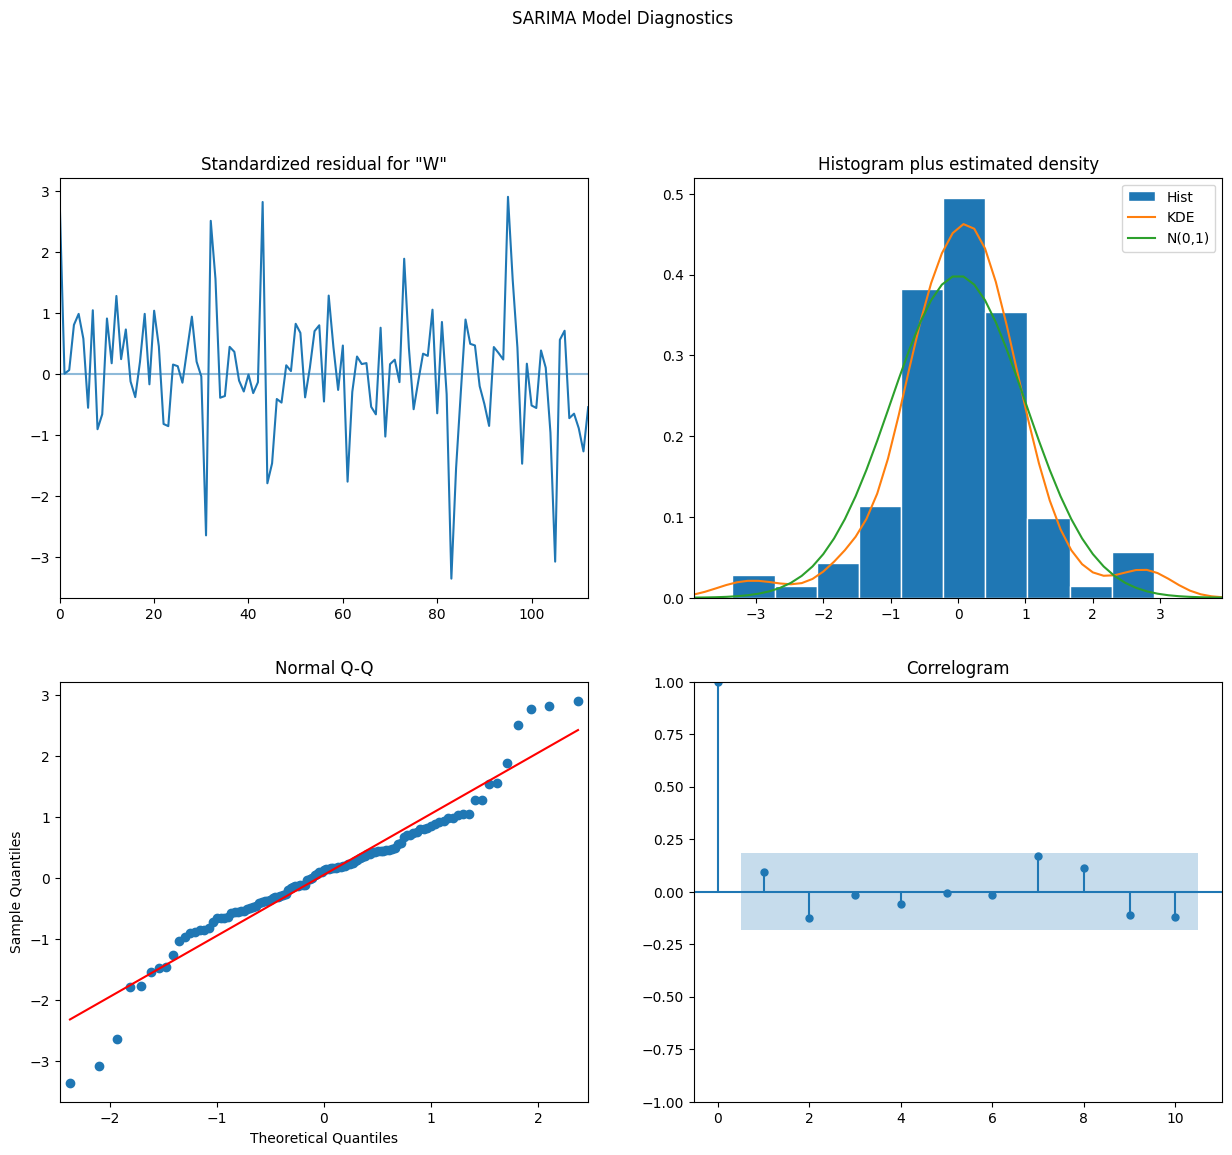

In [ ]:
sarima_result.plot_diagnostics(figsize=(15, 12))
plt.suptitle("SARIMA Model Diagnostics", y=1.02)
plt.show()

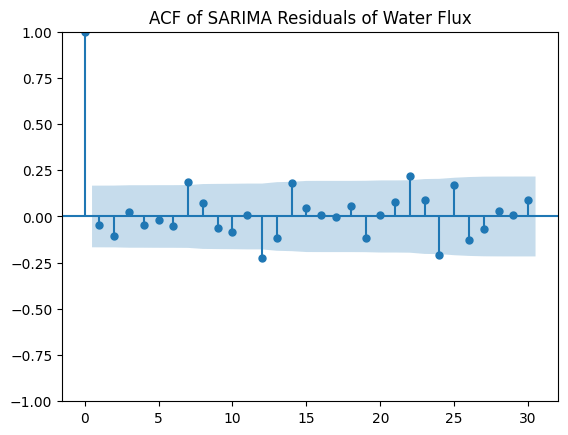

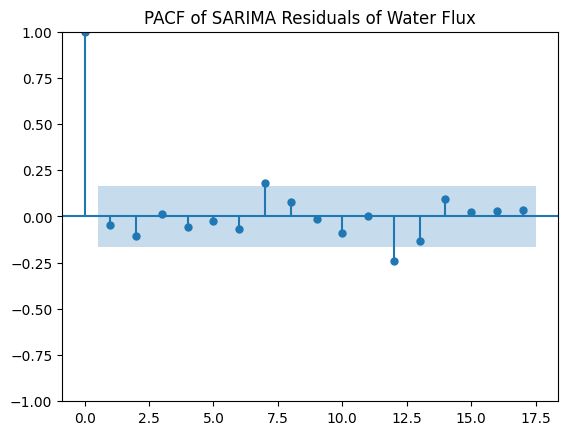

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


residuals = sarima_result.resid

plot_acf(residuals, lags=30)
plt.title("ACF of SARIMA Residuals of Water Flux")
plt.show()

plot_pacf(residuals, lags=17.5)
plt.title("PACF of SARIMA Residuals of Water Flux")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def mae(actual, predicted):
    return mean_absolute_error(actual, predicted)

def mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def r2(actual, predicted):
    return r2_score(actual, predicted)

def nrmse(actual, predicted):
    return rmse(actual, predicted) / (np.max(actual) - np.min(actual))

def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    epsilon = 1e-10
    actual_modified = np.where(actual == 0, epsilon, actual)
    return np.mean(np.abs((actual_modified - predicted) / actual_modified)) * 100


def mase(actual, predicted, seasonal_period=1):
    n = len(actual)
    errors = np.abs(actual - predicted)

    naive_errors = np.abs(actual[seasonal_period:] - actual[:-seasonal_period])

    naive_errors[naive_errors == 0] = 1e-10

    return np.mean(errors / np.mean(naive_errors))

def mfe(actual, predicted):
    return np.mean(actual - predicted)

def mpe(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)

    epsilon = 1e-10
    actual_modified = np.where(actual == 0, epsilon, actual)
    return np.mean((actual_modified - predicted) / actual_modified) * 100

def medae(actual, predicted):
    return np.median(np.abs(actual - predicted))

def mapd(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    epsilon = 1e-10
    actual_modified = np.where(actual == 0, epsilon, actual)
    return np.mean(np.abs((actual_modified - predicted) / actual_modified)) * 100

def tic(actual, predicted):
    numerator = np.sqrt(np.mean((predicted - actual)**2))
    denominator = np.sqrt(np.mean(predicted**2)) + np.sqrt(np.mean(actual**2))
    return numerator / denominator

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = {}

results= {
        'RMSE': rmse(test, sarima_forecast),
        'MAE': mae(test, sarima_forecast),
        'MSE': mse(test, sarima_forecast),
        'R-squared': r2(test, sarima_forecast),
        'NRMSE': nrmse(test, sarima_forecast),
        'MedAE': medae(test, sarima_forecast),
        'TIC': tic(test, sarima_forecast)
    }

for metric_name, value in results.items():
  print(f"  {metric_name}: {value:.4f}")

  RMSE: 0.6027
  MAE: 0.4505
  MSE: 0.3633
  R-squared: 0.4869
  NRMSE: 0.1692
  MedAE: 0.3107
  TIC: 0.4279


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


sarima_model = SARIMAX(water_df['WaterFlux Differenced'],
                       order=(1, 1, 1),
                       seasonal_order=(2, 1, 0, 24))
sarima_result = sarima_model.fit()


sarima_fitted_values = sarima_result.predict(start=0, end=train_size - 1)
sarima_forecast = sarima_result.predict(start=train_size, end=len(water_df) - 1)


residuals = water_df['WaterFlux Differenced'] - sarima_result.fittedvalues

water_df['Lag1'] = water_df['WaterFlux Differenced'].shift(1)
water_df['Lag2'] = water_df['WaterFlux Differenced'].shift(2)
water_df['RollingMean'] = water_df['WaterFlux Differenced'].rolling(window=3).mean()
water_df['Residuals'] = residuals

ml_data = water_df.dropna()

X = ml_data[['Lag1', 'Lag2', 'RollingMean']]
y = ml_data['Residuals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ml_model = SVR(kernel='rbf')
ml_model.fit(X_train, y_train)
ml_predictions_train = ml_model.predict(X_train)
ml_predictions_test = ml_model.predict(X_test)


sarima_fitted_values_aligned = sarima_fitted_values[ml_data.index[:len(X_train)]]

final_train_predictions = sarima_fitted_values_aligned + ml_predictions_train
final_test_predictions = sarima_forecast + ml_predictions_test

mse_train = mean_squared_error(y_train, ml_predictions_train)
mse_test = mean_squared_error(y_test, ml_predictions_test)
rmse_test=np.sqrt(mse_test)
rmse_train=np.sqrt(mse_train)
mae_train=mean_absolute_error(y_train, ml_predictions_train)
mae_test=mean_absolute_error(y_test, ml_predictions_test)

print(f"Hybrid Model Train RMSE: {rmse_test}")
print(f"Hybrid Model Test RMSE: {rmse_test}")
print(f"Hybrid Model Train MSE: {mse_train}")
print(f"Hybrid Model Test MSE: {mse_test}")
print(f"Hybrid Model Train MAE: {mae_train}")
print(f"Hybrid Model Test MAE: {mae_test}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Hybrid Model Train RMSE: 0.3330863926437176
Hybrid Model Test RMSE: 0.3330863926437176
Hybrid Model Train MSE: 0.10647778382216187
Hybrid Model Test MSE: 0.1109465449644048
Hybrid Model Train MAE: 0.21252184276415775
Hybrid Model Test MAE: 0.2444715259513888


In [ ]:
results = {}


results= {
        'RMSE': rmse(y_test, ml_predictions_test),
        'MAE': mae(y_test, ml_predictions_test),
        'MSE': mse(y_test, ml_predictions_test),
        'R-squared': r2(y_test, ml_predictions_test),
        'NRMSE': nrmse(y_test, ml_predictions_test),
        'MedAE': medae(y_test, ml_predictions_test),
        'TIC': tic(y_test, ml_predictions_test)
    }


for metric_name, value in results.items():
  print(f"  {metric_name}: {value:.4f}")

  RMSE: 0.3331
  MAE: 0.2445
  MSE: 0.1109
  R-squared: 0.6634
  NRMSE: 0.0958
  MedAE: 0.1242
  TIC: 0.3605


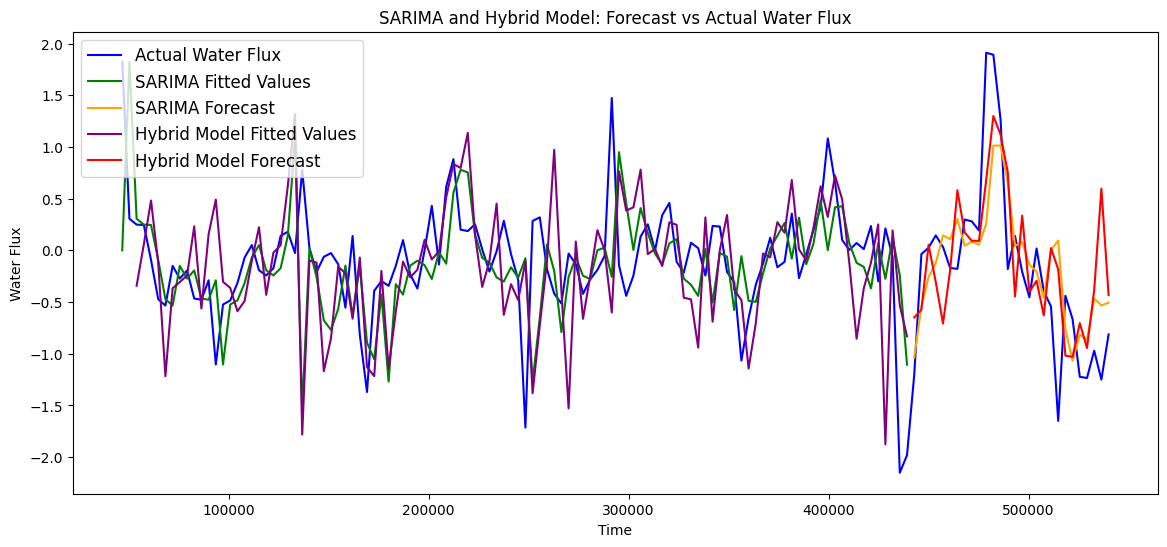

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(water_df['Time'], water_df['WaterFlux Differenced'], label="Actual Water Flux", color="blue")

plt.plot(water_df['Time'][:train_size], sarima_fitted_values, label="SARIMA Fitted Values", color="green")

plt.plot(water_df['Time'][train_size:], sarima_forecast, label="SARIMA Forecast", color="orange")


train_indices = ml_data.index[:len(X_train)]
plt.plot(water_df['Time'][train_indices], final_train_predictions, label="Hybrid Model Fitted Values", color="purple")

test_indices = ml_data.index[len(X_train):]
plt.plot(water_df['Time'][test_indices], final_test_predictions, label="Hybrid Model Forecast", color="red")

plt.title("SARIMA and Hybrid Model: Forecast vs Actual Water Flux")
plt.xlabel("Time")
plt.ylabel("Water Flux")
plt.legend(loc='upper left', fontsize=12, framealpha=0.8)
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ml_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated RMSE: {np.sqrt(-cv_scores.mean()):.4f}")

Cross-Validated RMSE: 0.4280


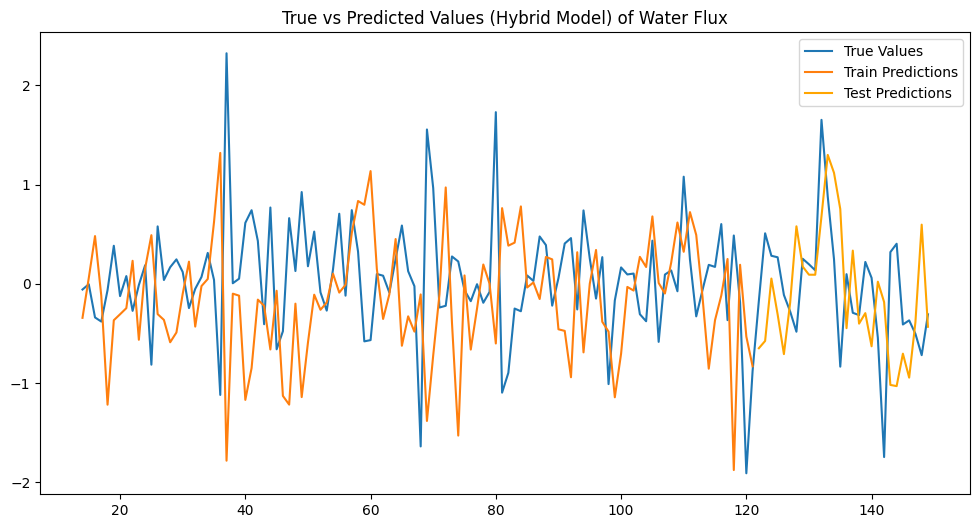

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ml_data.index, y, label="True Values")
plt.plot(ml_data.index[:len(y_train)], final_train_predictions, label="Train Predictions")
plt.plot(ml_data.index[len(y_train):], final_test_predictions, label="Test Predictions", color='orange')
plt.legend()
plt.title("True vs Predicted Values (Hybrid Model) of Water Flux")
plt.show()

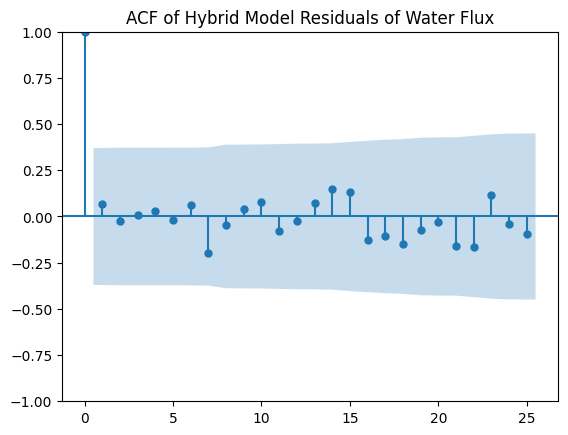

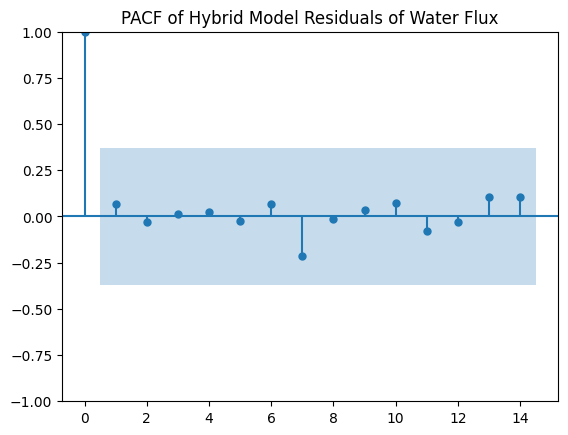

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

res=y_test - ml_predictions_test
plot_acf(res.dropna(),lags=25)
plt.title("ACF of Hybrid Model Residuals of Water Flux")
plt.show()

plot_pacf(res.dropna(),lags=14)
plt.title("PACF of Hybrid Model Residuals of Water Flux")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

n_lags = 3

for i in range(1, n_lags + 1):
    water_df[f'Lag_{i}'] = water_df['WaterFlux'].shift(i)

water_df.dropna(inplace=True)

X = water_df[['Lag_1', 'Lag_2', 'Lag_3']]
y = water_df['WaterFlux']

train_size = int(len(water_df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f"SVR with Lagged Features - RMSE: {rmse}, MAE: {mae}")

SVR with Lagged Features - RMSE: 0.5296182369925689, MAE: 0.37140533133691783


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

def rmse(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

def mae(actual, predicted):
  return mean_absolute_error(actual, predicted)

def mse(actual, predicted):
  return mean_squared_error(actual, predicted)



results= {
        'RMSE': rmse(y_test, y_pred),
        'MAE': mae(y_test, y_pred),
        'MSE': mse(y_test, y_pred),
        'NRMSE': nrmse(y_test, y_pred),
        'MedAE': medae(y_test, y_pred),
        'TIC': tic(y_test, y_pred)
    }

for metric_name, value in results.items():
  print(f"  {metric_name}: {value:.4f}")

  RMSE: 0.5296
  MAE: 0.3714
  MSE: 0.2805
  NRMSE: 0.3210
  MedAE: 0.1899
  TIC: 0.0238


<Figure size 1200x500 with 0 Axes>

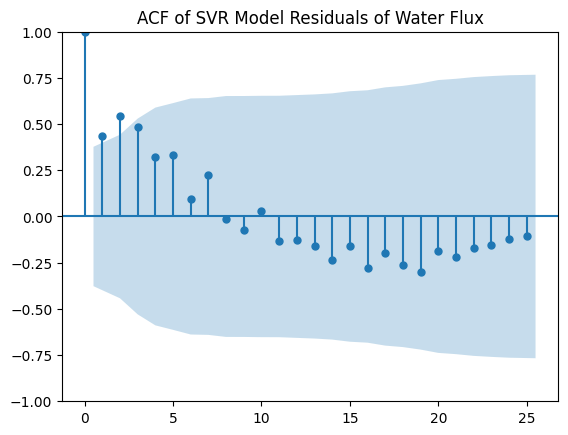

<Figure size 1200x500 with 0 Axes>

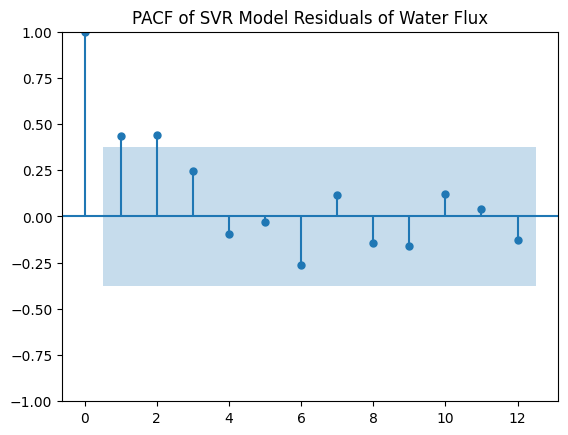

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


residuals = y_test - y_pred

residuals = residuals.dropna()


plt.figure(figsize=(12, 5))
plot_acf(residuals, lags=25)
plt.title("ACF of SVR Model Residuals of Water Flux")
plt.show()


plt.figure(figsize=(12, 5))
plot_pacf(residuals, lags=12)
plt.title("PACF of SVR Model Residuals of Water Flux")
plt.show()